In [52]:
# ✅ Step 1: Install AIF360
!pip install aif360


In [53]:
# ✅ Step 2: Download COMPAS dataset automatically
!mkdir -p data/compas
!wget -O data/compas/compas-scores-two-years.csv https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv


--2025-07-14 19:44:54--  https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2546489 (2.4M) [text/plain]
Saving to: ‘data/compas/compas-scores-two-years.csv’

data/compas/compas- 100%[===================>]   2.43M  7.57MB/s    in 0.3s    

2025-07-14 19:44:55 (7.57 MB/s) - ‘data/compas/compas-scores-two-years.csv’ saved [2546489/2546489]



In [54]:
# ✅ Step 3: Load and filter the dataset
import pandas as pd

# Load the dataset
df = pd.read_csv("data/compas/compas-scores-two-years.csv")

# Keep only relevant races and score categories
df = df[df['race'].isin(['African-American', 'Caucasian'])]
df = df[df['score_text'].isin(['Low', 'High'])]

# Drop rows with critical missing values
required_cols = ['score_text', 'race', 'age', 'sex', 'priors_count', 'juv_fel_count', 'juv_misd_count']
df = df.dropna(subset=required_cols)

# Map labels
df['score_text'] = df['score_text'].map({'Low': 1, 'High': 0})
df['race'] = df['race'].map({'Caucasian': 1, 'African-American': 0})

# One-hot encode 'sex'
df = pd.get_dummies(df, columns=['sex'], prefix='sex')

print("Final cleaned dataset size:", df.shape)

Final cleaned dataset size: (4423, 54)


In [55]:
# ✅ Step 4: Wrap in AIF360 StandardDataset
from aif360.datasets import StandardDataset

# Keep only relevant features for the dataset
features_to_keep = ['age', 'sex_Female', 'sex_Male', 'priors_count', 'juv_fel_count', 'juv_misd_count', 'race', 'score_text']
dataset = StandardDataset(df[features_to_keep],
    label_name='score_text',
    favorable_classes=[1],
    protected_attribute_names=['race'],
    privileged_classes=[[1]])

In [56]:
# ✅ Step 5: Fairness Metrics
from aif360.metrics import BinaryLabelDatasetMetric

privileged_groups = [{'race': 1}]  # White
unprivileged_groups = [{'race': 0}]  # Black

metric = BinaryLabelDatasetMetric(dataset, privileged_groups, unprivileged_groups)

print("Statistical Parity Difference:", metric.statistical_parity_difference())
print("Disparate Impact:", metric.disparate_impact())


Statistical Parity Difference: 0.25531270117526117
Disparate Impact: 1.4272545662900067


In [57]:
# ✅ Step 6: Train/Test Split and Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from aif360.metrics import ClassificationMetric

train, test = dataset.split([0.7], shuffle=True)

scaler = StandardScaler()
X_train = scaler.fit_transform(train.features)
X_test = scaler.transform(test.features)

y_train = train.labels.ravel()
y_test = test.labels.ravel()

model = LogisticRegression()
model.fit(X_train, y_train)

test_pred = test.copy()
test_pred.labels = model.predict(X_test).reshape(-1, 1)

classified_metric = ClassificationMetric(test, test_pred, unprivileged_groups, privileged_groups)
print("False Positive Rate Difference:", classified_metric.false_positive_rate_difference())


False Positive Rate Difference: -0.30316689782709205


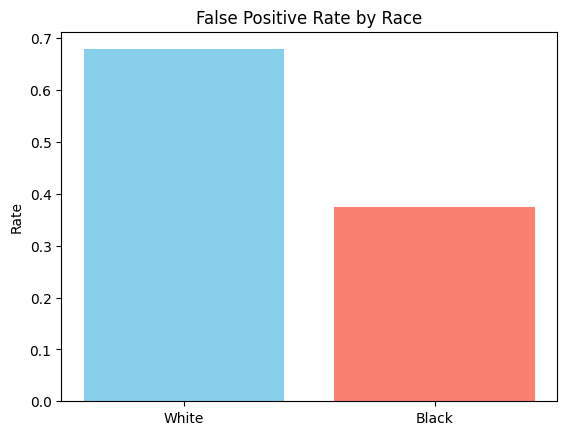

In [58]:
# ✅ Step 7: Visualize False Positive Rates by Race
import matplotlib.pyplot as plt

fpr_priv = classified_metric.false_positive_rate(privileged=True)
fpr_unpriv = classified_metric.false_positive_rate(privileged=False)

plt.bar(['White', 'Black'], [fpr_priv, fpr_unpriv], color=['skyblue', 'salmon'])
plt.title('False Positive Rate by Race')
plt.ylabel('Rate')
plt.show()
